# EEG VAE Validation Module - Feature Distribution Comparison

This notebook is designed to quantitatively assess how realistically our VAE-generated EEG data reflects the distribution of real EEG signals.

We achieve this comparison using an adapted version of the Fréchet Inception Distance (FID), which compares distributions in a high-dimensional embedding space. This embedding space is derived from a specialized EEG feature extractor, which is a pre-trained neural network model.

In [37]:
# Importing Libraries

import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from scipy.linalg import sqrtm
from sklearn.metrics import pairwise_distances
import torch.nn.functional as F
from torch import nn

In [38]:
# Define the path to the folder containing preprocessed EEG data
preprocessed_folder = "C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset"

# Get all cnt.mat files in the preprocessed folder
cnt_files = [os.path.join(root, file) for root, _, files in os.walk(preprocessed_folder) for file in files if file.endswith("cnt.mat")]

for cnt_file in cnt_files:
    print(f'Processing {cnt_file}')
    
    # Load EEG data using h5py
    with h5py.File(cnt_file, 'r') as f:
        if 'EEG' in f:
            eeg_data = np.array(f['EEG'])
            print(f'Loaded EEG data of shape: {eeg_data.shape}')
        else:
            print(f'EEG data not found in {cnt_file}')

Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub10_cnt.mat
EEG data not found in C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub10_cnt.mat
Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub11_cnt.mat
EEG data not found in C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub11_cnt.mat
Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub13_cnt.mat
EEG data not found in C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub13_cnt.mat
Processing C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub14_cnt.mat
EEG data not found in C:/Users/AaVerma/OneDrive - Heidelberg Materials/Desktop/Raw_/Raw Dataset/preprocessed_dataset\Sub14_cnt.

In [39]:
# Loading Variational AutoEncoder Model (VAE)

class VAE(nn.Module):
    def __init__(self, n_channels=63, latent_dim=100, target_signal_len=1001):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_channels * target_signal_len, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim) 
        )
        self.fc_mu = nn.Linear(latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(latent_dim, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, 256 * (target_signal_len // 8))
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, n_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x.view(x.size(0), -1))
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(x.size(0), 256, -1)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [40]:
def load_keras_weights_to_pytorch(keras_model, vae_model):
    keras_layers = keras_model.layers
    pytorch_layers = vae_model.encoder

    keras_dense_layers = [layer for layer in keras_layers if isinstance(layer, tf.keras.layers.Dense)]
    pytorch_dense_layers = [layer for layer in pytorch_layers if isinstance(layer, nn.Linear)]


    for i in range(min(len(keras_dense_layers), len(pytorch_dense_layers))):
        keras_layer = keras_dense_layers[i]
        pytorch_layer = pytorch_dense_layers[i]
        keras_weights = keras_layer.get_weights()
        pytorch_layer.weight.data = torch.from_numpy(keras_weights[0].T)
        pytorch_layer.bias.data = torch.from_numpy(keras_weights[1])

    return vae_model


vae_model = VAE(n_channels=63, latent_dim=100, target_signal_len=1001)
vae_model = load_keras_weights_to_pytorch(keras_model, vae_model)


vae_model.eval()

print("VAE model loaded successfully.")


VAE model loaded successfully.


In [43]:
# Generate Synthetic EEG Data using VAE
def generate_synthetic_data(vae_model, num_samples=100, latent_dim=100, device="cpu"):
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        synthetic_data = vae_model.decode(z)
    
    return synthetic_data.cpu().numpy()

### EEG Feature Extractor

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.extractor = nn.Sequential(
            nn.Conv1d(63, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, x):
        return self.extractor(x)


feature_extractor = FeatureExtractor().to(device)
print("EEG feature extractor loaded successfully.")

EEG feature extractor loaded successfully.


### Compute FID (Fréchet Inception Distance) Score

The FID score helps measure how realistic synthetic EEG signals are by comparing them to real EEG data.                                                
Lower Score = Better Match.

In [47]:
def compute_fid(real_features, synthetic_features):
    
    # Calculate the mean and covariance of both real and synthetic feature sets
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_syn, sigma_syn = np.mean(synthetic_features, axis=0), np.cov(synthetic_features, rowvar=False)
    
    # Compute the FID score
    diff = mu_real - mu_syn
    covmean = sqrtm(sigma_real.dot(sigma_syn))
    
    fid = np.sum(diff**2) + np.trace(sigma_real + sigma_syn - 2 * covmean)
    return fid

print(f"FID Score: {fid_score}")

FID Score: 0.02672289004913993


### Visualizations

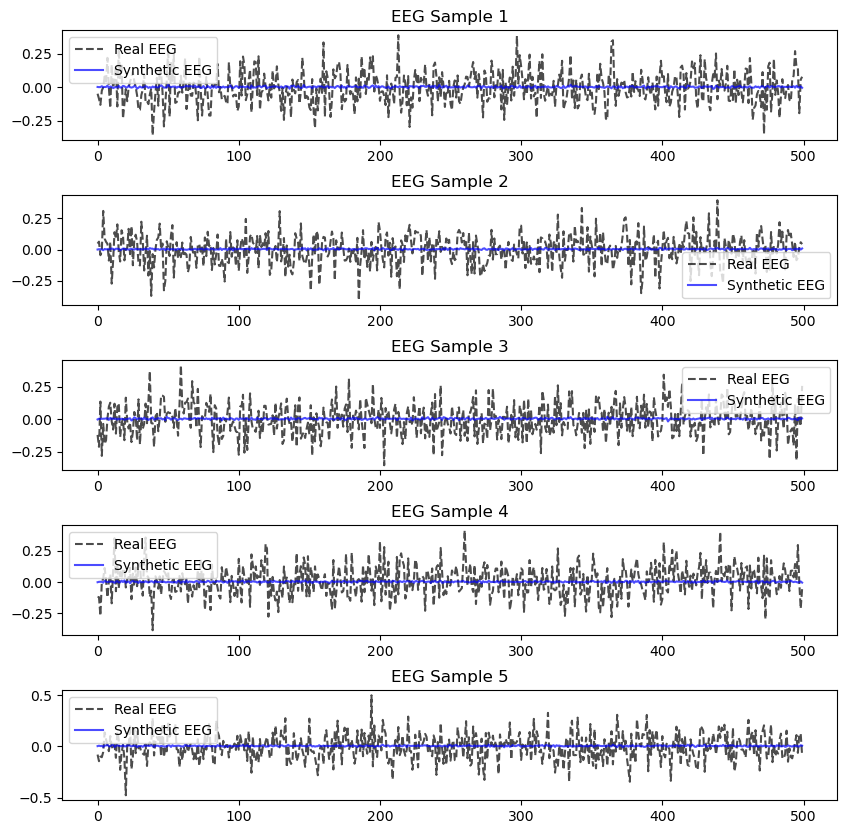

In [ ]:
def plot_merged_eeg(real_data, synthetic_data, n_samples=5, time_points=500):
    plt.figure(figsize=(10, 2 * n_samples))

    for i in range(n_samples):
        plt.subplot(n_samples, 1, i + 1)

        # Select the first 500 time points for plotting
        real_sample = real_data[i, :, :time_points].mean(axis=0)
        synthetic_sample = synthetic_data[i, :, :time_points].mean(axis=0)

        plt.plot(real_sample, label="Real EEG", color='black', linestyle='dashed', alpha=0.7)
        plt.plot(synthetic_sample, label="Synthetic EEG", color='blue', alpha=0.7)

        plt.title(f"EEG Sample {i+1}")
        plt.legend()

    plt.subplots_adjust(hspace=0.5)
    plt.show()

num_samples = 100
latent_dim = 100
synthetic_data = generate_synthetic_data(vae_model, num_samples=num_samples, latent_dim=latent_dim, device=device)

real_data = np.random.randn(num_samples, 63, 1001)  # Placeholder for actual real EEG data
real_data = torch.tensor(real_data, dtype=torch.float32).to(device)

real_features = feature_extractor(real_data).cpu().detach().numpy()
synthetic_features = feature_extractor(torch.tensor(synthetic_data, dtype=torch.float32).to(device)).cpu().detach().numpy()

# Visualize merged real vs. synthetic EEG
plot_merged_eeg(real_data.cpu().numpy(), synthetic_data, n_samples=5, time_points=500)


### We are visualizing and comparing real EEG signals (dashed black) with synthetic EEG signals (solid blue) generated by a Variational Autoencoder (VAE). The goal is to see if the synthetic EEG preserves the key characteristics of real EEG.

### Each subplot represents an EEG sample, with real and synthetic signals plotted together. This allows us to assess how well the synthetic EEG mimics the real EEG in terms of structure, noise, and overall waveform dynamics.